# Delineate basins 1-by-1
This is a working script used to delineate basins using the MERIT Hydro data (DEM, flow direction, basin discretization). CAMELS-US and RHBN metadata about station locations do not always lead to accurate basin delineation. In this script we go through the basins one by one, so that we can manually modify the outlet location in the CAMELS-spat metadata file for basins for which the original station or outlet location is not a good fit with the MERIT DEM. This also lets us add extra notes about the confidence we have in this manually moved outlet and therefore the resulting basin outline. 

Workflow:
1. Load the required data:
    1. CAMELS-spat metadata file
    2. MERIT Hydro DEM
    3. MERIT Hydro flow direction
    4. MERIT Hydro basin discretization
2. Manually loop over all catchments. For each catchment:
    1. Read the station or outlet locations
    2. Delineate basin from station/outlet location:
        1. Create a subset of the GeoTIFF files for quicker processing
        2. Delineate basin
        3. Get the appropriate MERIT Hydro shapefiles
        4. Fix up the most downstream MERIT Hydro polygon
    3. Perform checks and add results to metadata file
        1. Calculate new basin area
        2. If reference area(s) exist, print a comparison
        3. If reference shapefile exists, compute overlap between reference and new shape
    4. Make a decision:
        1. If area and overlap are OK, use the current station or outlet location
        2. If no area or reference shape are available, do a manual check
        3. If area and overlap are not OK, go to file `1_manually_define_outlets` and:
            1. Update outlet location
            2. Record what changes were made and why
    5. Save new shape:
        1. As a lumped catchment discretization
        2. As a spatially-distributed discretization
3. Save the updated metadata file

In [1]:
import sys
import pandas as pd
import geopandas as gpd
from pathlib import Path
sys.path.append(str(Path().absolute().parent))
import python_cs_functions as cs

### Config handling

In [2]:
# Specify where the config file can be found
config_file = '../0_config/config.txt'

In [3]:
# Get the required info from the config file
data_path     = cs.read_from_config(config_file,'data_path')

# CAMELS-spat metadata
cs_meta_path  = cs.read_from_config(config_file,'cs_basin_path')
cs_meta_name  = cs.read_from_config(config_file,'cs_meta_name')

# MERIT Hydro data
merit_path = cs.read_from_config(config_file, 'merit_path')
merit_acc = Path(data_path) / merit_path / 'flow_accumulation_grid' / 'merit_hydro_acc.tif'
merit_dir = Path(data_path) / merit_path / 'flow_direction_grid' / 'merit_hydro_dir.tif'
merit_bas = Path(data_path) / merit_path / 'shapes' / 'basins' / 'cat_pfaf_7_8_MERIT_Hydro_v07_Basins_v01_bugfix1_hillslopes_pfaf_7_8_clean_fixed.shp'
merit_riv = Path(data_path) / merit_path / 'shapes' / 'rivers' / 'riv_pfaf_7_8_MERIT_Hydro_v07_Basins_v01_bugfix1.shp'

# Basin folder
cs_basin_folder = cs.read_from_config(config_file, 'cs_basin_path')

### Data loading

In [4]:
# CAMELS-spat metadata file
cs_meta_path = Path(data_path) / cs_meta_path
cs_meta = pd.read_csv(cs_meta_path / cs_meta_name)

In [5]:
# Shapefiles
basins_shp = gpd.read_file(merit_bas)
rivers_shp = gpd.read_file(merit_riv)

## DEV

In [6]:
# Create a temporary directory for subsetting files
tmp_dir = Path(data_path) / 'tmp'
tmp_dir.mkdir(parents=True, exist_ok=True)

In [7]:
ii = 0

In [8]:
# 1. Prepare file paths and names
# --------------------------------------------------------------------------------------
shp_lump_path, shp_dist_path = cs.prepare_delineation_outputs(cs_meta, ii, Path(data_path)/cs_basin_folder)
print(shp_lump_path, '\n', shp_dist_path)

C:\Globus endpoint\CAMELS_spat\camels-spat-data\basin_data\CAN_01AD002\shapefiles\lumped\lumped_01AD002.shp 
 C:\Globus endpoint\CAMELS_spat\camels-spat-data\basin_data\CAN_01AD002\shapefiles\distributed\distributed_01AD002_{}.shp


In [9]:
# 2. Get the station or outlet location
# --------------------------------------------------------------------------------------
lat,lon = cs.read_delineation_coords(cs_meta,ii)
print(lat,lon)

47.2577 -68.59414


In [10]:
# 3. Delineate the basin
# --------------------------------------------------------------------------------------

In [11]:
# 3a. Subset the Geotiffs for quicker processing
subset_window = cs.determine_pysheds_data_loading_window(lat,lon, str(merit_acc))
print(subset_window)

temp_acc,temp_dir = cs.subset_tifs_around_gauge(subset_window, 
                                               str(merit_acc), 
                                               str(merit_dir),
                                               temp_dir = tmp_dir)
print(temp_acc, temp_dir)

(-83.59414, 37.2577, -53.594139999999996, 57.2577)
C:\Globus endpoint\CAMELS_spat\tmp\small_acc.tif C:\Globus endpoint\CAMELS_spat\tmp\small_fdir.tif


In [12]:
# 3b. Extract the full basin with pysheds
grid,acc,fdir = cs.load_tifs_with_pysheds(str(temp_acc),str(temp_dir))

In [13]:
lump_basin = cs.delineate_catchment_with_pysheds(grid,lon,lat,fdir,shp_lump_path)

<AxesSubplot: >

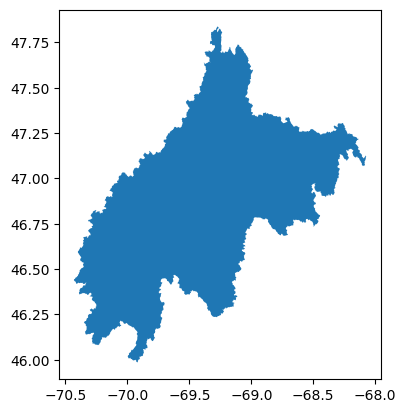

In [14]:
lump_basin.plot()

In [41]:
# 3c. Extract the MERIT Hydro basins and river network
dist_basin, dist_river = subset_merit_hydro_to_basin(basins_shp, rivers_shp, lump_basin, shp_dist_path)

C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\tools\clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\geopandas\tools\clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [38]:
def subset_merit_hydro_to_basin(basins, rivers, mask, shapefile_path):
    
    '''Subsets the larger MERIT Hydro shapes (basins and rivers) to the delineated lumped basin outline. 
    
    This /should/ work because both lumped and existing MERIT Hydro basin delineations are based on the 
    same DEM, and therefore lumped basin outline should map almost perfectly on the existing MERIT Hydro
    outlines. As an added benefit we automatically subset the most downstream MERIT Hydro sub-basin to
    end exactly at the station location.
    
    Inputs:
    - basins: MERIT Hydro basin delineation in EPSG:4326
    - rivers: MERIT Hydro river delineation in EPSG:4326
    - mask: Lumped catchment outline delineated with Pysheds in EPSG:4326
    - shapefile_path: path and name of where to save the resulting .shp, with a wildcard to add basin/river specification.
                      Example: /path/to/shape_{}.shp
    
    Returns:
    - Shapefile containing the distributed basin outlines
    - Shapefile containing the distributed river locations
    '''
    
    import geopandas as gpd
    
    # Basins
    dist_basin = subset_shape(basins, mask, 'COMID')
    dist_basin['unitarea'] = calculate_area(dist_basin, ) # Area of most downstream geometry needs to be updated
    dist_basin.to_file( str(shp_dist_path).format('basins') )
    
    # Rivers
    dist_river = subset_shape(rivers, mask, 'COMID')
    dist_river.to_file( str(shp_dist_path).format('river') )
    
    return dist_basin, dist_river

In [40]:
def subset_shape(shape_in, mask, dissolve_column):
    
    '''Subsets a shape by another and dissolves the result based on column values.
    
    This is needed because the MERIT Hydro basins and the lumped shape overlap almost
    exactly, and this results in tons of very small polygons along the edges of the 
    lumped shape when using Geopandas.clip(MERIT, lumped).
    
    Inputs:
    - shape_in: larger shape
    - mask: smaller shape
    - dissolve_column: name of the column to dissolve by
    
    Returns:
    - Subset of [shape_in] to [mask], dissolved by [dissolve_column]
    '''
    
    # Get the cut-out
    # keep_geom_type = True ensures we end up with just polygons and not Linestrings, because Linestrings don't save nicely
    shape_out = gpd.clip(shape_in, mask, keep_geom_type=True)
    
    # Merge all 1-pixel polygons into their parent polygon
    shape_out = shape_out.dissolve(by=dissolve_column)
    
    return shape_out

In [ ]:
def calculate_area(shape, crs='ESRI:102008'):
    
    '''Calculates the area for each geometry inside a shapefile using the specified Coordinate Reference System'''
    
    
    

In [45]:
dist_basin_albers = dist_basin.to_crs('ESRI:102008')

In [49]:
dist_basin_albers['new_area'] = dist_basin_albers.area / 10**6

In [50]:
dist_basin_albers

,geometry,unitarea,new_area
COMID,,,
72034983,"POLYGON ((1870243.339 1153615.133, 1870270.642...",4.787341,4.787341e+00
72035003,"MULTIPOLYGON (((1893156.099 1147998.252, 18931...",236.375941,2.155653e-07
72035038,"POLYGON ((1865240.688 1152170.306, 1865295.148...",44.897822,4.489782e+01
72036048,"MULTIPOLYGON (((1870042.021 1161331.330, 18700...",37.734791,3.773479e+01
72036142,"POLYGON ((1869304.173 1163879.626, 1869440.810...",9.269285,9.269285e+00
...,...,...,...
73000406,"MULTIPOLYGON (((1884010.519 995100.619, 188406...",98.408483,4.822220e-08
73000409,"MULTIPOLYGON (((1916748.286 1013719.442, 19167...",88.432548,2.890867e-07
73000411,"MULTIPOLYGON (((1881819.785 1009209.440, 18818...",77.054231,5.962680e-13


In [15]:
from shapely.validation import make_valid

In [35]:
def fix_geom(in_feature):
    
    '''Fixes polygon geometries if invalid
       
       Source: https://stackoverflow.com/a/71231092
       Modified by Wouter Knoben, University of Saskatchewan, 2022
    '''

    # avoid changing original geodf
    in_feature = in_feature.copy(deep=True)    
        
    # drop any missing geometries
    in_feature = in_feature[~(in_feature.is_empty)]
    
    # Repair broken geometries
    for index, row in in_feature.iterrows(): # Looping over all polygons
        if row['geometry'].is_valid:
            next
        else:
            fix = make_valid(row['geometry'])

            try:
                in_feature.loc[[index],'geometry'] =  fix # issue with Poly > Multipolygon
            except ValueError:
                in_feature.loc[[index],'geometry'] =  in_feature.loc[[index], 'geometry'].buffer(0)
    return in_feature

In [38]:
full_basin.is_valid

0    False
dtype: bool

In [39]:
lump_basin_fixed = fix_geom(lump_basin)

C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\numpy\core\fromnumeric.py:3156: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  return asarray(a).ndim
C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\numpy\core\fromnumeric.py:3156: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return asarray(a).ndim
C:\Globus endpoint\CAMELS_spat\camels-spat-env\lib\site-packages\pandas\core\indexing.py:1836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(ilocs) == 1 and lplane_in

In [19]:
# 4. Update metadata with delineation outcomes
# --------------------------------------------------------------------------------------
basin_area = cs.get_merit_hydro_accumulated_upstream_area(grid,acc,lon,lat)
print(basin_area)

14664.864


## END DEV

### Delineation

In [22]:
def delineation_loop(i):
    
    '''Delineates basin for station at index i in the CAMELS-spat metadata file'''
    
    # Input:
    # i - index in CAMELS-spat metadata file to process
    
    # 1. Prepare file paths and names
    # --------------------------------------------------------------------------------------
    shp_lump_path, shp_dist_path = cs.prepare_delineation_outputs(cs_meta,i)
    
    # 2. Get the station or outlet location
    # --------------------------------------------------------------------------------------
    lat,lon = cs.read_delineation_coords(cs_meta,i)
    
    # 3. Delineate the basin
    # --------------------------------------------------------------------------------------
    # 3a. Subset the Geotiffs for quicker processing
    subset_window = cs.determine_pysheds_data_loading_window(lat,lon, str(merit_acc))
    temp_acc,temp_dir = cs.subset_tifs_around_gauge(subset_window, 
                                                    str(merit_acc), 
                                                    str(merit_dir),
                                                    temp_dir = tmp_dir)
    
    # 3b. Extract the full basin with pysheds
    grid,acc,fdir = cs.load_tifs_with_pysheds(temp_acc,temp_dir) # Load the GeoTIFFs
    lump_basin = cs.delineate_catchment_with_pysheds(grid,lon,lat,fdir,shp_lump_path) # Saves lumped file as part of function
        
    # 3c. Extract the MERIT Hydro basins and river network
    
    
    
    # 4. Update metadata with delineation outcomes
    # --------------------------------------------------------------------------------------
    basin_area = cs.get_merit_hydro_accumulated_upstream_area(grid,acc,lon,lat) # [km^2]
    
    
    return

In [11]:
cs_meta

,Country,Station_id,Station_name,Station_lat,Station_lon,Station_source,Outlet_lat,Outlet_lon,Outlet_source,Basin_area_km2,Ref_area_1_src,Ref_area_1_km2,Ref_area_2_src,Ref_area_2_km2,Ref_shape,Ref_shape_source,Ref_shape_area_km2
0,CAN,01AD002,SAINT JOHN RIVER AT FORT KENT,47.25806,-68.59583,WSC 20222 data set,47.257877,-68.594919,WSC 20222 data set,-999,HYDAT gross drainage area,14700.00,HYDAT effective drainage area,NaN,yes,WSC 2022 data set,14677.400000
1,CAN,01AD003,ST. FRANCIS RIVER AT OUTLET OF GLASIER LAKE,47.20661,-68.95694,WSC 20222 data set,47.206016,-68.956727,WSC 20222 data set,-999,HYDAT gross drainage area,1350.00,HYDAT effective drainage area,NaN,yes,WSC 2022 data set,1348.300000
2,CAN,01AE001,FISH RIVER NEAR FORT KENT,47.23750,-68.58278,WSC 20222 data set,47.237438,-68.581991,WSC 20222 data set,-999,HYDAT gross drainage area,2260.00,HYDAT effective drainage area,NaN,yes,WSC 2022 data set,2238.950000
3,CAN,01AF007,GRANDE RIVIERE AT VIOLETTE BRIDGE,47.24697,-67.92128,WSC 20222 data set,47.246908,-67.921271,WSC 20222 data set,-999,HYDAT gross drainage area,339.00,HYDAT effective drainage area,NaN,yes,WSC 2022 data set,325.196000
4,CAN,01AF009,IROQUOIS RIVER AT MOULIN MORNEAULT,47.45783,-68.35683,WSC 20222 data set,47.457622,-68.356710,WSC 20222 data set,-999,HYDAT gross drainage area,182.00,HYDAT effective drainage area,NaN,yes,WSC 2022 data set,183.430000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1693,USA,14309500,"WEST FORK COW CREEK NEAR GLENDALE, OR",42.80400,-123.61091,CAMELS-US,-999.000000,-999.000000,NaN,-999,GAGES II area,224.92,Geospatial fabric area,226.31,yes,CAMELS-US data set (HCDN),226.314346
1694,USA,14316700,"STEAMBOAT CREEK NEAR GLIDE, OR",43.34984,-122.72894,CAMELS-US,-999.000000,-999.000000,NaN,-999,GAGES II area,587.90,Geospatial fabric area,588.01,yes,CAMELS-US data set (HCDN),588.025033
1695,USA,14325000,"SOUTH FORK COQUILLE RIVER AT POWERS, OR",42.89150,-124.07065,CAMELS-US,-999.000000,-999.000000,NaN,-999,GAGES II area,443.07,Geospatial fabric area,444.92,yes,CAMELS-US data set (HCDN),444.925651
1696,USA,14362250,"STAR GULCH NEAR RUCH, OR.",42.15401,-123.07532,CAMELS-US,-999.000000,-999.000000,NaN,-999,GAGES II area,41.42,Geospatial fabric area,43.88,yes,CAMELS-US data set (HCDN),43.877901


In [10]:
# Create a temporary directory for subsetting files
tmp_dir = Path(data_path) / 'tmp'
tmp_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
# Remove the temporary directory